# Finetune a stable diffusion model for text to image generation

***
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart).  In this demo notebook, we demonstrate how to use the JumpStart API to generate images from text using state-of-the-art Stable Diffusion models. Furthermore, we show how to fine-tune the model to your dataset.

Stable Diffusion is a text-to-image model that enables you to create photorealistic images from just a text prompt. A diffusion model trains by learning to remove noise that was added to a real image. This de-noising process generates a realistic image. These models can also generate images from text alone by conditioning the generation process on the text. For instance, Stable Diffusion is a latent diffusion where the model learns to recognize shapes in a pure noise image and gradually brings these shapes into focus if the shapes match the words in the input text.

Training and deploying large models and running inference on models such as Stable Diffusion is often challenging and include issues such as cuda out of memory, payload size limit exceeded and so on.  JumpStart simplifies this process by providing ready-to-use scripts that have been robustly tested. Furthermore, it provides guidance on each step of the process including the recommended instance types, how to select parameters to guide image generation process, prompt engineering etc. Moreover, you can deploy and run inference on any of the 80+ Diffusion models from JumpStart without having to write any piece of your own code.


In his notebook, you will learn how to use JumpStart to fine-tune the Stable Diffusion model to your dataset. This can be useful when creating art, logos, custom designs, NFTs, and so on, or fun stuff such as generating custom AI images of your pets or avatars of yourself.


Model lincese: By using this model, you agree to the [CreativeML Open RAIL-M++ license](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL).

***

1. [Set Up](#1.-Set-Up)
2. [Fine-tune the pre-trained model on a custom dataset](#2.-Fine-tune-the-pre-trained-model-on-a-custom-dataset)
    * [Retrieve Training Artifacts](#2.1.-Retrieve-Training-Artifacts)
    * [Set Training parameters](#2.2.-Set-Training-parameters)
    * [Start Training](#2.3.-Start-Training)
    * [Deploy and run inference on the fine-tuned model](#3.2.-Deploy-and-run-inference-on-the-fine-tuned-model)
3. [Conclusion](#3.-Conclusion)


Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

Note: For fine-tuning the model on your dataset, you need `ml.g4dn.2xlarge` instance type available in your account. To deploy the fine-trained model, you can use `ml.p3.2xlarge` or `ml.g4dn.2xlarge` instance types. If `ml.g5.2xlarge` is available in your region, we recommend using that instance type for deployment. 

## 1. Set Up

***
Before executing the notebook, there are some initial steps required for set up. This notebook requires latest version of sagemaker.

***

#### Permissions and environment variables

***
To host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access.

***

In [1]:
install_needed = True  # should only be True once
# install_needed = False

In [2]:
%%bash
#!/bin/bash

DAEMON_PATH="/etc/docker"
MEMORY_SIZE=10G

FLAG=$(cat $DAEMON_PATH/daemon.json | jq 'has("data-root")')
# echo $FLAG

if [ "$FLAG" == true ]; then
    echo "Already revised"
else
    echo "Add data-root and default-shm-size=$MEMORY_SIZE"
    sudo cp $DAEMON_PATH/daemon.json $DAEMON_PATH/daemon.json.bak
    sudo cat $DAEMON_PATH/daemon.json.bak | jq '. += {"data-root":"/home/ec2-user/SageMaker/.container/docker","default-shm-size":"'$MEMORY_SIZE'"}' | sudo tee $DAEMON_PATH/daemon.json > /dev/null
    sudo service docker restart
    echo "Docker Restart"
fi

Add data-root and default-shm-size=10G
Docker Restart


Redirecting to /bin/systemctl restart docker.service


In [3]:
import sys
import IPython

if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U smdebug sagemaker-experiments
    !{sys.executable} -m pip install -U sagemaker
    !{sys.executable} -m pip install -U accelerate diffusers transformers
    # !{sys.executable} -m pip install accelerate==0.15.0 diffusers==0.11.1 transformers==4.25.1
    IPython.Application.instance().kernel.do_shutdown(True)

installing deps and restarting kernel
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 5.8 MB/s eta 0:00:0000:01
  Using cached sagemaker_experiments-0.1.43-py3-none-any.whl (42 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 24.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 743.3/743.3 kB 10.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.148.0-py2.py3-none-any.whl size=998496 sha256=7f6d87c1557bd616cda06b7f90d1a7f050806ffe6975cef96bf4ec38df6f27cc
  Stored in directory: /home/ec2-user/.cache/pip/wheels/66/36/07/56de705f4ad8ea09e40419f57f8478bc60aae5b1e095dda1f0
Successfully built sagemaker
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.0
    Uninstalling cloudpickle-2.

In [116]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

## 2. Fine-tune the pre-trained model on a custom dataset

---
Previously, we saw how to run inference on a pre-trained model. Next, we discuss how a model can be finetuned to a custom dataset with any number of classes.

The model can be fine-tuned to any dataset of images. It works very well even with as little as five training images.

The fine-tuning script is built on the script from [dreambooth](https://dreambooth.github.io/). The model returned by fine-tuning can be further deployed for inference. Below are the instructions for how the training data should be formatted.

- **Input:** A directory containing the instance images, `dataset_info.json` and (optional) directory `class_data_dir`.
  - Images may be of `.png` or `.jpg` or `.jpeg` format.
  - `dataset_info.json` file must be of the format {'instance_prompt':<<instance_prompt>>,'class_prompt':<<class_prompt>>}.
  - If with_prior_preservation = False, you may choose to ignore 'class_prompt'.
  - `class_data_dir` directory must have class images. If with_prior_preservation = True and class_data_dir is not present or there are not enough images already present in class_data_dir, additional images will be sampled with class_prompt.
- **Output:** A trained model that can be deployed for inference.

The s3 path should look like `s3://bucket_name/input_directory/`. Note the trailing `/` is required.

Here is an example format of the training data.

    input_directory
        |---instance_image_1.png
        |---instance_image_2.png
        |---instance_image_3.png
        |---instance_image_4.png
        |---instance_image_5.png
        |---dataset_info.json
        |---class_data_dir
            |---class_image_1.png
            |---class_image_2.png
            |---class_image_3.png
            |---class_image_4.png

**Prior preservation, instance prompt and class prompt:** Prior preservation is a technique that uses additional images of the same class that we are trying to train on.  For instance, if the training data consists of images of a particular dog, with prior preservation, we incorporate class images of generic dogs. It tries to avoid overfitting by showing images of different dogs while training for a particular dog. Tag indicating the specific dog present in instance prompt is missing in the class prompt. For instance, instance prompt may be "a photo of a Doppler dog" and class prompt may be "a photo of a dog". You can enable prior preservation by setting the hyper-parameter with_prior_preservation = True.



We provide a default dataset of dog images. It consists of images (instance images corresponding to instance prompt) of a single dog with no class images. If using the default dataset, try the prompt "a photo of a Doppler dog" while doing inference in the demo notebook.


License: [MIT](https://github.com/marshmellow77/dreambooth-sm/blob/main/LICENSE).

### 2.1. Retrieve Training Artifacts

---
Here, we retrieve the training docker container, the training algorithm source, and the pre-trained base model. Note that model_version="*" fetches the latest model.

---

In [117]:
from sagemaker import image_uris, model_uris, script_uris

# Currently, not all the stable diffusion models in jumpstart support finetuning. Thus, we manually select a model
# which supports finetuning.
train_model_id, train_model_version, train_scope = (
    "model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    "*",
    "training",
)

# Tested with ml.g4dn.2xlarge (16GB GPU memory) and ml.g5.2xlarge (24GB GPU memory) instances. Other instances may work as well.
# If ml.g5.2xlarge instance type is available, please change the following instance type to speed up training.
training_instance_type = "ml.g4dn.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the training script. This contains all the necessary files including data processing, model training etc.
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

### 2.2. Set Training parameters

---
Now that we are done with all the set up that is needed, we are ready to train our stable diffusion model. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job.

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training. We defined the training instance type above to fetch the correct train_image_uri.

The second set of parameters are algorithm specific training hyper-parameters.

---

In [118]:
# Sample training data is available in this bucket
training_data_bucket = f"jumpstart-cache-prod-{aws_region}"
training_data_prefix = "training-datasets/dogs_sd_finetuning/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-sd-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [119]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["max_steps"] = "400"
print(hyperparameters)

{'epochs': '20', 'max_steps': '400', 'batch_size': '1', 'with_prior_preservation': 'False', 'num_class_images': '100', 'learning_rate': '2e-06', 'prior_loss_weight': '1.0', 'center_crop': 'False', 'lr_scheduler': 'constant', 'adam_weight_decay': '0.01', 'adam_beta1': '0.9', 'adam_beta2': '0.999', 'adam_epsilon': '1e-08', 'gradient_accumulation_steps': '1', 'max_grad_norm': '1.0', 'compute_fid': 'False', 'seed': '0'}


---
If setting `with_prior_preservation=True`, please use ml.g5.2xlarge instance type as more memory is required to generate class images. Currently, training on ml.g4dn.2xlarge instance type run into CUDA out of memory issue when setting `with_prior_preservation=True`.

---

### 2.3. Start Training
---
We start by creating the estimator object with all the required assets and then launch the training job.  It takes less than 10 mins on the default dataset.

---

- angry : model-txt2img-stabilityai-stable-diffus-2023-04-19-21-40-15-172
- calm : model-txt2img-stabilityai-stable-diffus-2023-04-19-21-50-11-408
- confused : model-txt2img-stabilityai-stable-diffus-2023-04-19-22-05-13-449

In [120]:
feeling='disgusted'

In [121]:
# training_instance_type='ml.g4dn.2xlarge'
training_instance_type='ml.g5.2xlarge'
# training_instance_type='ml.g4dn.4xlarge'

In [122]:
training_egarden_s3_path = f's3://dataset-us-west-2-cyj/stable-diffusion-finetune/data_crawling/{feeling}-nature/'
# training_egarden_s3_path = f's3://dataset-us-west-2-cyj/stable-diffusion-finetune/face-image/'

In [124]:
# name_from_base(f"jumpstart-example-{train_model_id}-transfer-learning")[23:]

In [125]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = feeling + name_from_base(f"jumpstart-example-{train_model_id}-transfer-learning")[23:]

# Create SageMaker Estimator instance
sd_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir="train_code",
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",  # Entry-point file in source_dir and present in train_source_uri.
    instance_count=1,
    instance_type=training_instance_type,
    # max_run=360000,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    # base_job_name=training_job_name,
)


In [126]:
# Launch a SageMaker Training job by passing s3 path of the training data
sd_estimator.fit(
    job_name=training_job_name,
    inputs={"training": training_egarden_s3_path}, 
    logs=True,
    wait=False
)

Using provided s3_resource


INFO:sagemaker:Creating training-job with name: disgusted-txt2img-stabili-2023-04-23-14-05-21-008


In [128]:
sd_estimator.logs()

2023-04-23 14:26:14 Starting - Preparing the instances for training
2023-04-23 14:26:14 Downloading - Downloading input data
2023-04-23 14:26:14 Training - Training image download completed. Training in progress.
2023-04-23 14:26:14 Uploading - Uploading generated training model
2023-04-23 14:26:14 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-23 14:10:20,340 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-23 14:10:20,361 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-23 14:10:20,363 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-23 14:10:21,554 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
Processing ./lib/accelerate/accelerate-0.15.0-py3-none-any

### 2.4. Deploy and run inference on the fine-tuned model

---

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the bounding boxes of an image. We follow the same steps as in [2. Run inference on the pre-trained model](#2.-Run-inference-on-the-pre-trained-model). We start by retrieving the jumpstart artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `od_estimator` that we fine-tuned.

---

In [1]:
import base64
import json
import logging
import os
from copy import copy
from io import BytesIO
from typing import Any
from typing import Dict
from typing import List
from typing import Optional
from typing import Union

import numpy as np
import torch
from src.constants import constants
from diffusers import EulerDiscreteScheduler
from diffusers import StableDiffusionPipeline as Txt2ImgPipeline
from PIL import Image
# from sagemaker_inference import encoder
from transformers import set_seed

In [130]:
!aws s3 cp $sd_estimator.model_data ./model/



download: s3://sagemaker-us-west-2-322537213286/jumpstart-example-sd-training/output/disgusted-txt2img-stabili-2023-04-23-14-05-21-008/output/model.tar.gz to model/model.tar.gz


In [132]:
!mkdir model_dir

In [133]:
!tar -xvzf model/model.tar.gz -C model_dir

feature_extractor/
feature_extractor/preprocessor_config.json
model_index.json
vae/
vae/config.json
vae/diffusion_pytorch_model.bin
code/
code/constants/
code/constants/__init__.py
code/constants/constants.py
code/version
code/script_requirements.txt
code/requirements.txt
code/lib/
code/lib/accelerate/
code/lib/accelerate/accelerate-0.15.0-py3-none-any.whl
code/lib/scipy/
code/lib/scipy/scipy-1.9.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
code/lib/diffusers/
code/lib/diffusers/diffusers-0.11.1-py3-none-any.whl
code/lib/transformers/
code/lib/transformers/transformers-4.25.1-py3-none-any.whl
code/inference.py
tokenizer/
tokenizer/vocab.json
tokenizer/merges.txt
tokenizer/special_tokens_map.json
tokenizer/tokenizer_config.json
scheduler/
scheduler/scheduler_config.json
unet/
unet/config.json
unet/diffusion_pytorch_model.bin
text_encoder/
text_encoder/config.json
text_encoder/pytorch_model.bin


In [2]:
def _validate_payload(payload: Dict[str, Any]) -> None:
    """Validate the parameters in the input loads.

    Checks if height, width, num_inference_steps and num_images_per_prompt are integers.
    Checks if height and width are divisible by 8.
    Checks if guidance_scale, num_return_sequences, num_beams, top_p and temprature are in bounds.
    Checks if do_sample is boolean.
    Checks max_length, num_return_sequences, num_beams and seed are integers.
    Args:
        payload: a decoded input payload (dictionary of input parameter and values)
    """

    for param_name in payload:
        if param_name not in constants.ALL_PARAM_NAMES:
            raise KeyError(
                f"Input payload contains an invalid key {param_name}. Valid keys are {constants.ALL_PARAM_NAMES}."
            )
    if constants.PROMPT not in payload:
        raise KeyError(f"Input payload must contain '{constants.PROMPT}' key.")

    for param_name in [
        constants.HEIGHT,
        constants.WIDTH,
        constants.NUM_INFERENCE_STEPS,
        constants.NUM_IMAGES_PER_PROMPT,
        constants.SEED,
    ]:
        if param_name in payload:
            if type(payload[param_name]) != int:
                raise ValueError(f"{param_name} must be an integer, got {payload[param_name]}.")

    for param_name in [constants.GUIDANCE_SCALE, constants.ETA]:
        if param_name in payload:
            if type(payload[param_name]) != float and type(payload[param_name]) != int:
                raise ValueError(f"{param_name} must be an int or float, got {payload[param_name]}.")

    if constants.HEIGHT in payload:
        if payload[constants.HEIGHT] % 8 != 0:
            raise ValueError(f"{constants.HEIGHT} must be divisible by 8, got {payload[constants.HEIGHT]}.")
    if constants.WIDTH in payload:
        if payload[constants.WIDTH] % 8 != 0:
            raise ValueError(f"{constants.WIDTH} must be divisible by 8, got {payload[constants.WIDTH]}.")
    for param_name in [constants.NUM_INFERENCE_STEPS, constants.NUM_IMAGES_PER_PROMPT, constants.BATCH_SIZE]:
        if param_name in payload:
            if payload[param_name] < 1:
                raise ValueError(f"{param_name} must be at least 1, got {payload[param_name]}.")
                
def encode_image_jpeg(image: Image.Image) -> str:
    """Encode the image with base64.b64 encoding after converting JPEG format and loading as bytes."""
    out = BytesIO()
    image.save(out, format=constants.JPEG_FORMAT)
    generated_image_bytes = out.getvalue()
    generated_image_encoded = base64.b64encode(generated_image_bytes).decode()
    return generated_image_encoded


def _set_default_width_height(payload: Dict[str, Any]) -> Dict[str, Any]:
    """Set the default width and height if not in the input payload."""

    if constants.WIDTH not in payload:
        payload[constants.WIDTH] = constants.DEFAULT_WIDTH_PIXELS
    if constants.HEIGHT not in payload:
        payload[constants.HEIGHT] = constants.DEFAULT_HEIGHT_PIXELS
    return payload


def generate_images_in_batches(dreamer: Txt2ImgPipeline, payload: Dict[str, Any]) -> List[Image.Image]:
    """Split the list into batches, run inference on each items, return the list of generated image.

    Create a list of prompts of size (#prompts)*num_images_per_prompt.

    Default batch size is assumed to be 1.
    """

    num_images_per_prompt = payload.get(constants.NUM_IMAGES_PER_PROMPT, 1)

    payload_prompt = payload[constants.PROMPT]
    negative_payload_prompt = payload.get(constants.NEGATIVE_PROMPT)
    negative_prompt_delineated_list: Optional[List[str]] = None
    if isinstance(payload_prompt, list):
        prompts_delineated_list = [prompt for prompt in payload_prompt for _ in range(num_images_per_prompt)]
        if negative_payload_prompt:
            negative_prompt_delineated_list = [
                negative_prompt for negative_prompt in negative_payload_prompt for _ in range(num_images_per_prompt)
            ]
    elif isinstance(payload_prompt, str):
        prompts_delineated_list = [payload_prompt for _ in range(num_images_per_prompt)]
        if negative_payload_prompt:
            negative_prompt_delineated_list = [negative_payload_prompt for _ in range(num_images_per_prompt)]
    else:
        raise ValueError(f"{constants.PROMPT} must be a string or a list of string. Got {payload_prompt}.")

    batch_size = payload.get(constants.BATCH_SIZE, 1)
    print(f"batch_size : {batch_size}")
    generated_images: List[Image.Image] = []
    for pos in range(0, len(prompts_delineated_list), batch_size):
        # Construct the batch paylod to be fed into the model.
        # There are num_images_per_prompt copies of each prompt in payload_delineated_list. So, we ignore the parameter
        # in the batch_payload.
        # Batch size is a parameter to the script only. Model does not support batch_size parameter. So, we ignore the
        # batch_size parameter in batch_payload.
        batch_payload = {
            x: y
            for x, y in payload.items()
            if x
            not in [constants.PROMPT, constants.BATCH_SIZE, constants.NUM_IMAGES_PER_PROMPT, constants.NEGATIVE_PROMPT]
        }

        batch_payload[constants.PROMPT] = prompts_delineated_list[pos : pos + batch_size]
        if negative_payload_prompt:
            batch_payload[constants.NEGATIVE_PROMPT] = negative_prompt_delineated_list[pos : pos + batch_size]
        generated_images.extend(dreamer(**batch_payload).images)
        torch.cuda.empty_cache()
    return generated_images



def parse_response_multiple_images(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"], response_dict["prompt"]

In [3]:
model_dir = './model_dir/'

In [4]:
model = Txt2ImgPipeline.from_pretrained(model_dir, torch_dtype=torch.float16)
dreamer = model.to(constants.CUDA)

In [17]:
import torch
import torch.nn as nn

import os
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.models.unet_2d_condition import UNet2DConditionOutput

from diffusers.models.cross_attention import CrossAttention


class UNetWrap(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        out_tuple = self.unet(sample, timestep, encoder_hidden_states, return_dict=False)
        return out_tuple

class NeuronUNet(nn.Module):
    def __init__(self, unetwrap):
        super().__init__()
        self.unetwrap = unetwrap
        self.config = unetwrap.unet.config
        self.in_channels = unetwrap.unet.in_channels
        self.device = unetwrap.unet.device
        self.dtype = constants.CUDA

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        sample = self.unetwrap(sample, timestep.float().expand((sample.shape[0],)), encoder_hidden_states)[0]
        return UNet2DConditionOutput(sample=sample)

def get_attention_scores(self, query, key, attn_mask):       
    dtype = query.dtype
    print(f"dtype : {dtype}")
    if self.upcast_attention:
        query = query.float()
        key = key.float()

    if(query.size() == key.size()):
        attention_scores = cust_badbmm(
            key,
            query.transpose(-1, -2)
        )

        if self.upcast_softmax:
            attention_scores = attention_scores.float()

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=1).permute(0,2,1)
        attention_probs = attention_probs.to(dtype)

    else:
        attention_scores = cust_badbmm(
            query,
            key.transpose(-1, -2)
        )

        if self.upcast_softmax:
            attention_scores = attention_scores.float()

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = attention_probs.to(dtype)
        
    return attention_probs

def cust_badbmm(a, b):
    bmm = torch.bmm(a, b)
    scaled = bmm * 0.125
    return scaled


# For saving compiler artifacts
# COMPILER_WORKDIR_ROOT = 'sd2_compile_dir'

# model_id = "stabilityai/stable-diffusion-2-1-base"
# model = Txt2ImgPipeline.from_pretrained(model_dir)
# dreamer = model.to(constants.CUDA)
pipe = StableDiffusionPipeline.from_pretrained(model_dir, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# Replace original cross-attention module with custom cross-attention module for better performance
CrossAttention.get_attention_scores = get_attention_scores

pipe.unet = NeuronUNet(UNetWrap(pipe.unet))

pipe = pipe.to(constants.CUDA)

# Compile unet - FP32
sample_1b = torch.randn([1, 4, 64, 64])
timestep_1b = torch.tensor(999).float().expand((1,))
encoder_hidden_states_1b = torch.randn([1, 77, 1024])
example_inputs = sample_1b, timestep_1b, encoder_hidden_states_1b

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(
/tmp/ipykernel_49745/2311218403.py:25: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  self.in_channels = unetwrap.unet.in_channels


In [18]:
torch.cuda.empty_cache()

# from numba import cuda
# device = cuda.get_current_device()
# device.reset()


In [12]:
text = "best quality, botanic garden with (disgusted nature: 25.5), (sunny: 10.5), (white winter: 10.5), (day: 7), () [real artisation: illustration: 0.5], ((back to the viewer)), (an extremely delicate) by Francisco Jose de Goya y Lucientes and Otto Dix"
payload = {
    "prompt": text,
    "width": 768,
    "height": 768,
    "num_images_per_prompt": 1,
    "num_inference_steps": 50,
    "guidance_scale": 7.5,
}

In [13]:
img_name = './result/test.jpeg'

In [14]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [15]:
def predict(dreamer, payload, img_name):
    content_type, accept = "application/json", "application/json;jpeg"
    _validate_payload(payload)
    if constants.SEED in payload:
        set_seed(payload[constants.SEED])
        del payload[constants.SEED]
    payload = _set_default_width_height(payload)


    generated_images: List[Image.Image] = []
    try:
        generated_images = generate_images_in_batches(dreamer, payload)

        if constants.JPEG_ACCEPT_EXTENSION in accept:
            output = {
                constants.GENERATED_IMAGES: [encode_image_jpeg(image) for image in generated_images],
                constants.PROMPT: payload[constants.PROMPT],
            }
            accept = accept.replace(constants.JPEG_ACCEPT_EXTENSION, "")
        else:
            output = {
                constants.GENERATED_IMAGES: [np.asarray(generated_img) for generated_img in generated_images],
                constants.PROMPT: payload[constants.PROMPT],
            }
    except torch.cuda.OutOfMemoryError as e:
        logging.error(
            "Model ran out of CUDA memory while generating images. Please reduce height and width or "
            f"deploy the model on an instance type with more GPU memory. Error: {e}."
        )
        raise
    except Exception:
        logging.exception("Failed to generate images.")
        raise
    finally:
        if generated_images:
            for generated_image in generated_images:
                generated_image.close()

    generated_images = output['generated_images']
    for generated_image in generated_images:
        generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
        generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
        generated_image_rgb.save(img_name)



In [23]:
import time 
start = time.time()

predict(dreamer, payload, img_name)

end = time.time() - start
print("total time: ",end, "seconds")

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['y lucientes and otto dix']


batch_size : 1


  0%|          | 0/50 [00:00<?, ?it/s]

total time:  10.057640790939331 seconds


In [25]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

  0%|          | 0/50 [00:00<?, ?it/s]

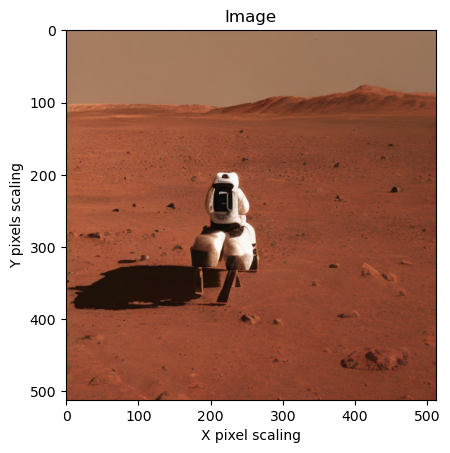

  0%|          | 0/50 [00:00<?, ?it/s]

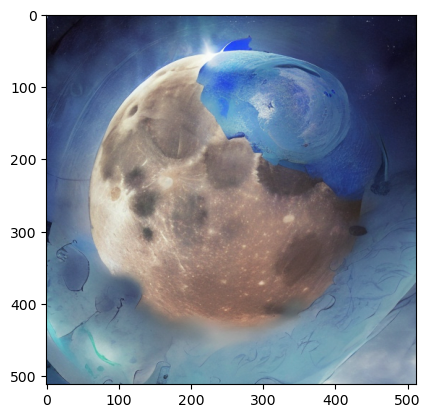

  0%|          | 0/50 [00:00<?, ?it/s]

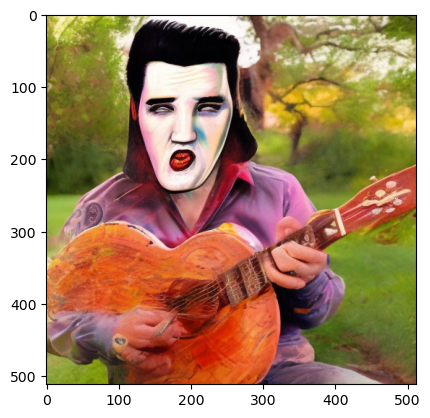

  0%|          | 0/50 [00:00<?, ?it/s]

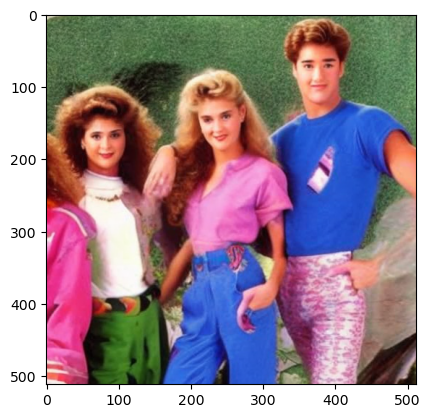

  0%|          | 0/50 [00:00<?, ?it/s]

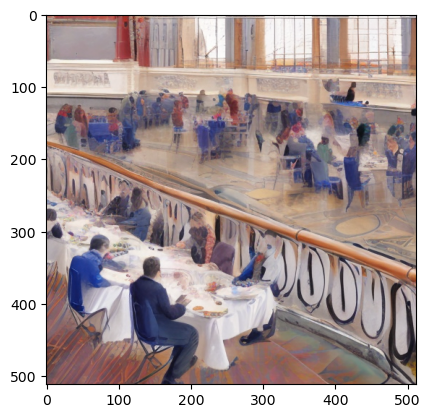

  0%|          | 0/50 [00:00<?, ?it/s]

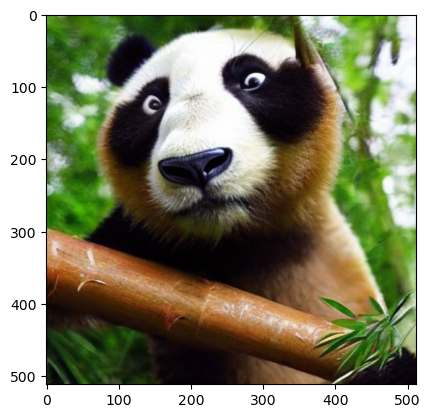

  0%|          | 0/50 [00:00<?, ?it/s]

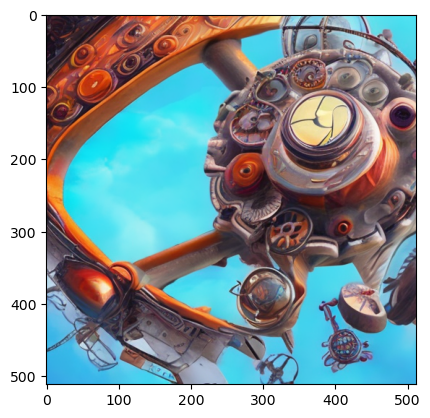

  0%|          | 0/50 [00:00<?, ?it/s]

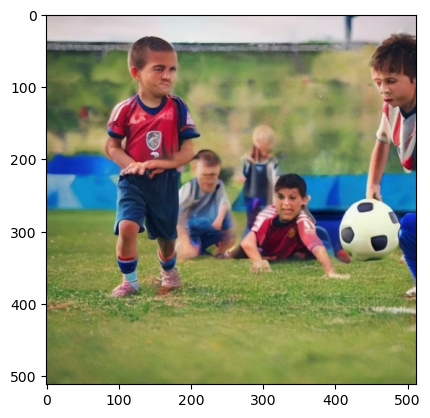

Average time:  3.48 seconds


In [26]:

 # Run pipeline
prompt = ["a photo of an astronaut riding a horse on mars",
          "sonic on the moon",
          "elvis playing guitar while eating a hotdog",
          "saved by the bell",
          "engineers eating lunch at the opera",
          "panda eating bamboo on a plane",
          "A digital illustration of a steampunk flying machine in the sky with cogs and mechanisms, 4k, detailed, trending in artstation, fantasy vivid colors",
          "kids playing soccer at the FIFA World Cup"
         ]

plt.title("Image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

total_time = 0
for x in prompt:
    start_time = time.time()
    image = dreamer(x).images[0]
    total_time = total_time + (time.time()-start_time)
    image.save("image.png")
    image = mpimg.imread("image.png")
    #clear_output(wait=True)
    plt.imshow(image)
    plt.show()
print("Average time: ", np.round((total_time/len(prompt)), 2), "seconds")

In [22]:
torch.cuda.empty_cache()

In [36]:
import random
import os
from time import strftime

In [37]:
feeling = 'disgusted'
animal = ['dog', 'cat', '']
season = ['spring','summer','autumn','winter']
weather = ['sunny','cloudy','rainy', 'snowy']
times = ['day','sunset','the-middle-of-the-night','the-early-dawn']
num_images_per_category = 2

In [40]:
for s in season:
    for w in weather:
        for i, th in enumerate(times):
            dir_path = f'result/{feeling}/{s},{w},{th}/'
            os.makedirs(dir_path, exist_ok=True)
            time = strftime("%Y%m%d-%H%M%S")
            a = random.choice(animal)
            text = f"best quality, botanic garden with (disgusted nature: 20.5), ({w}: 3.5), ({s}: 2.5), ({th}: 3), ({a}) [real artisation: illustration: 0.5], ((back to the viewer)), (an extremely delicate)"
            # print(text)
            if i >= int(num_images_per_category/2):
                k = i - int(num_images_per_category/2)
                # width = 800
                # height = 1280
                width = 720
                height = 1080
                img_name = dir_path+ f'img_{time}_{k}v.jpeg'
            else:
                # width = 1280
                # height = 800
                width = 1080
                height = 720
                img_name = dir_path+ f'img_{time}_{i}h.jpeg'
                
            payload = {
                "prompt": text,
                "width": width,
                "height": height,
                "num_images_per_prompt": 1,
                "num_inference_steps": 150,
                "guidance_scale": 7.5,
            }
            print(f"prompt : {text}")
            predict(pipe, payload, img_name)
        


prompt : best quality, botanic garden with (disgusted nature: 20.5), (sunny: 3.5), (spring: 2.5), (day: 3), (dog) [real artisation: illustration: 0.5], ((back to the viewer)), (an extremely delicate)
batch_size : 1


  0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
!tar -cvf disgusted.tar ./result/disgusted/

./result/disgusted/
./result/disgusted/spring,snowy,sunset/
./result/disgusted/spring,snowy,sunset/img_20230421-232959_1v.jpeg
./result/disgusted/spring,snowy,sunset/.ipynb_checkpoints/
./result/disgusted/spring,snowy,sunset/.ipynb_checkpoints/img_20230421-232959_1v-checkpoint.jpeg
./result/disgusted/spring,snowy,sunset/img_20230422-000747_0v.jpeg
./result/disgusted/autumn,cloudy,sunset/
./result/disgusted/autumn,cloudy,sunset/img_20230422-003035_0v.jpeg
./result/disgusted/autumn,snowy,the-early-dawn/
./result/disgusted/autumn,snowy,the-early-dawn/img_20230422-004005_2v.jpeg
./result/disgusted/winter,sunny,the-middle-of-the-night/
./result/disgusted/winter,sunny,the-middle-of-the-night/img_20230422-004255_1v.jpeg
./result/disgusted/autumn,snowy,the-middle-of-the-night/
./result/disgusted/autumn,snowy,the-middle-of-the-night/img_20230422-003908_1v.jpeg
./result/disgusted/winter,rainy,the-middle-of-the-night/
./result/disgusted/winter,rainy,the-middle-of-the-night/img_20230422-005031_1v.

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response

def query_prompt(model_predictor, payload):
    """Query the model predictor."""

    encoded_payload = json.dumps(payload).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_payload,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response

def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

In [5]:
# text = 'botanic garden with (dog: 2.0) and (bugs), very extremely (disgusted: 3.5) nature, (((dizziness and discomfort))), psychedelic, best quality, (sunny: 3.0), (spring: 2.5), surrealist, hyperrealistic, cinematic lighting, dramatic angle, wide angle view, yellow and ((green)), by Ernst Ludwig Kirchner and Wassily Kandinsky, [real artisation: illustration: 0.4], (day: 2.0)'
text = 'botanic garden with (dog: 2.0) and (bugs), very extremely (confused: 3.5) nature, (((dizziness and discomfort))), psychedelic, best quality, (sunny: 3.0), (spring: 2.5), surrealist, hyperrealistic, cinematic lighting, dramatic angle, wide angle view, yellow and ((green)), by Ernst Ludwig Kirchner, Wassily Kandinsky and Edvard Munch, [real artisation: illustration: 0.4], (day: 2.0)'
# text = 'botanic garden with (dog: 2.0) and (bugs), very extremely (disgusted: 3.5) nature, (((dizziness and discomfort))), psychedelic, best quality, (sunny: 3.0), (spring: 2.5), surrealist, hyperrealistic, cinematic lighting, dramatic angle, low angle shot, yellow and ((green)), by Ernst Ludwig Kirchner and Wassily Kandinsky, [real artisation: illustration: 0.4], (day: 2.0)'


In [6]:
text = 'best quality, botanic garden with (disgusted nature: 20.5), (sunny: 3.5), (spring: 2.5), (day: 3), (dog) [real artisation: illustration: 0.5], ((back to the viewer)), (an extremely delicate)'

In [7]:
# text = "a photo of a dog with a hat"
# text = 'botanic garden with flowers and (no animal: 2.0), very strong (surprised: 10.5) nature, best quality, (sunny: 3.0), (spring: 2.5), surrealist, hyperrealistic, fantasy, cinematic lighting, dramatic angle, expansive view, real artisation, (day: 2.0)'
# text = 'best quality, dreamlikeart, disgusted nature, rainy, winter, real Artstation, botanical garden, flowers, cinematic lighting, dramatic angle, ((back to the viewer)), (an extremely delicate and beautiful), day'

# text = 'best quailty, botanic garden with (disgusted nature: 10.5) and flowers'

query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

NameError: name 'finetuned_predictor' is not defined

In [67]:
text

'best quality, botanic garden with (disgusted nature: 20.5), (sunny: 3.5), (spring: 2.5), (day: 3), (dog) [real artisation: illustration: 0.5], ((back to the viewer)), (an extremely delicate)'

In [1]:
payload = {
    "prompt": text,
    "width": 512,
    "height": 512,
    "num_images_per_prompt": 1,
    "num_inference_steps": 50,
    "guidance_scale": 5.5,
}

NameError: name 'text' is not defined

In [73]:
query_response = query_prompt(finetuned_predictor, payload)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

NameError: name 'query_prompt' is not defined

In [70]:
# text = "best quality,kyoungsu as handsome guy, digital painting, hyperrealistic, highly detailed, animation ,extremely detailed by Hayao Miyazaki by Hayao Miyazaki and Alphonse Mucha"

In [71]:
import json

# Training data for different models had different image sizes and it is often observed that the model performs best when the generated image
# has dimensions same as the training data dimension. For dimensions not matching the default dimensions, it may result in a black image.
# Stable Diffusion v1-4 was trained on 512x512 images and Stable Diffusion v2 was trained on 768x768 images.
def query_endpoint_with_json_payload(model_predictor, payload, content_type, accept):
    """Query the model predictor with json payload."""

    encoded_payload = json.dumps(payload).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_payload,
        {
            "ContentType": content_type,
            "Accept": accept,
        },
    )
    return query_response


def parse_response_multiple_images(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"], response_dict["prompt"]


In [72]:
# text = 'best quality, botanic garden with (cat: 2.0) and (bugs), very extremely (disgusted: 3.5) nature, \
#         (((dizziness and discomfort))), psychedelic, (sunny: 3.0), (spring: 2.5), surrealist, hyperrealistic, cinematic lighting, dramatic angle, low angle shot by Vladimir Feoktistov, [real artisation: illustration: 0.4], (day: 2.0)'

In [347]:
# text= 'best quailty, botanic garden with (disgusted nature: 10.5) and flowers, illustration, surrealist, hyperrealistic'

In [371]:
text = "best quality, botanic garden with (disgusted nature: 50.5), sunny, spring, [real artisation: illustration: 0.5], ((back to the viewer)), (an extremely delicate)"

In [442]:
import random
import os
from time import strftime

In [443]:
feeling = 'disgusted'
animal = ['dog', 'cat', '']
season = ['spring','summer','autumn','winter']
weather = ['sunny','cloudy','rainy', 'snowy']
times = ['day','sunset','the-middle-of-the-night','the-early-dawn']
num_images_per_category = 1

In [444]:
for s in season:
    for w in weather:
        for i, th in enumerate(times):
            dir_path = f'result/{feeling}/{s},{w},{th}/'
            os.makedirs(dir_path, exist_ok=True)
            time = strftime("%Y%m%d-%H%M%S")
            a = random.choice(animal)
            text = f"best quality, botanic garden with (disgusted nature: 50.5), {w}, {s}, {th}, {a} [real artisation: illustration: 0.5], ((back to the viewer)), (an extremely delicate)"
            # print(text)
            if i >= int(num_images_per_category/2):
                k = i - int(num_images_per_category/2)
                width = 800
                height = 1280
                img_name = dir_path+ f'img_{time}_{k}v.jpeg'
            else:
                width = 1280
                height = 800
                img_name = dir_path+ f'img_{time}_{i}h.jpeg'
                
            payload = {
                "prompt": text,
                "width": width,
                "height": height,
                "num_images_per_prompt": 1,
                "num_inference_steps": 150,
                "guidance_scale": 7.5,
            }
            
            query_response = query_endpoint_with_json_payload(
                finetuned_predictor, payload, "application/json", "application/json;jpeg"
            )

            generated_images, prompt = parse_response_multiple_images(query_response)
            for generated_image in generated_images:
                generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
                generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
                generated_image_rgb.save(img_name)
            



ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from primary with message "{
  "code": 400,
  "type": "InternalServerException",
  "message": "module \u0027torch.cuda\u0027 has no attribute \u0027OutOfMemoryError\u0027"
}
". See https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/jumpstart-example-FT-model-txt2img-stab-2023-04-21-14-28-39-496 in account 322537213286 for more information.

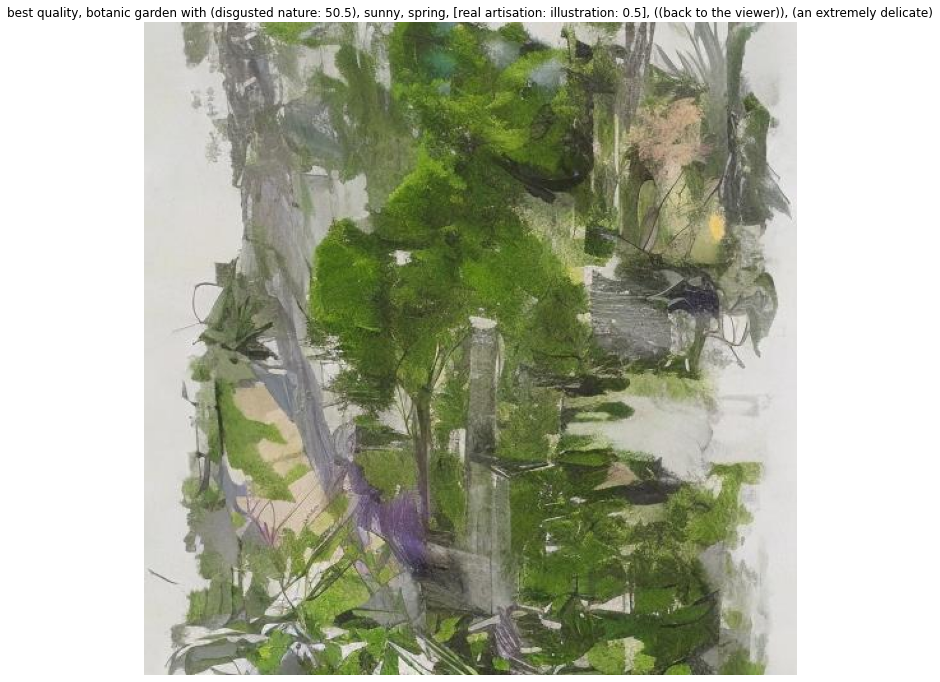

In [373]:
from PIL import Image
from io import BytesIO
import base64
import json

query_response = query_endpoint_with_json_payload(
    finetuned_predictor, payload, "application/json", "application/json;jpeg"
)

generated_images, prompt = parse_response_multiple_images(query_response)

# generated_images are a list of jpeg images as bytes with b64 encoding.


def display_encoded_images(generated_images, prompt):
    # we decode the images and convert to RGB format before displaying
    for generated_image in generated_images:
        generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
        generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
        display_img_and_prompt(generated_image_rgb, prompt)


display_encoded_images(generated_images, prompt)

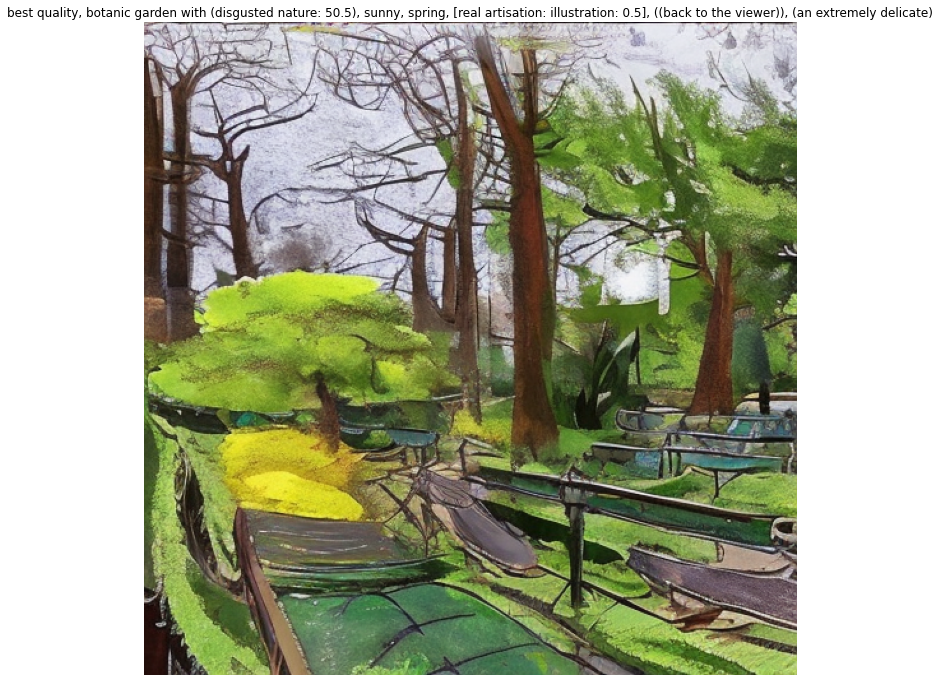

In [370]:
text = "best quality, botanic garden with (disgusted nature: 50.5), sunny, spring, [real artisation: illustration: 0.5], ((back to the viewer)), (an extremely delicate)"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

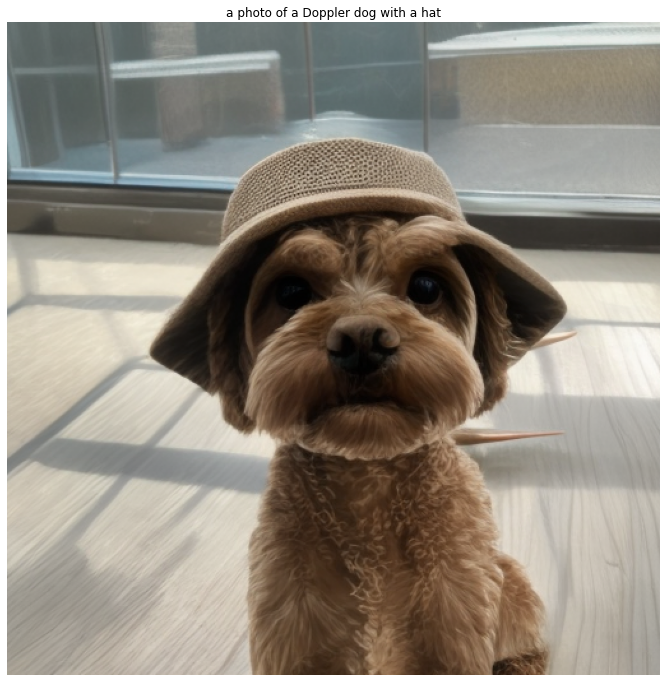

In [21]:
text = "a photo of a Doppler dog with a hat"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

All the parameters mentioned in [2.4. Supported Inference parameters](#2.4.-Supported-Inference-parameters) are supported with finetuned model as well. You may also receive compressed image output as in [2.5. Compressed Image Output](#2.5.-Compressed-Image-Output) by changing `accept`.

---
Next, we delete the endpoint corresponding to the finetuned model.

---

In [ ]:
# Delete the SageMaker endpoint
finetuned_predictor.delete_model()
finetuned_predictor.delete_endpoint()

## 3. Conclusion
---

Although creating impressive images can find use in industries ranging from art to NFTs and beyond, today we also expect AI to be personalizable. JumpStart provides fine-tuning capability to the pre-trained models so that you can adapt the model to your own use case with as little as five training images. This can be useful when creating art, logos, custom designs, NFTs, and so on, or fun stuff such as generating custom AI images of your pets or avatars of yourself. In this lab, we learned how to fine-tune a stable diffusion text to image generation model. To learn more about Stable Diffusion fine-tuning, please check out the blog [Fine-tune text-to-image Stable Diffusion models with Amazon SageMaker JumpStart](https://aws.amazon.com/blogs/machine-learning/fine-tune-text-to-image-stable-diffusion-models-with-amazon-sagemaker-jumpstart/).

In [18]:
import glob

In [19]:
result_path = './result'
val = len(glob.glob(result_path + '/*/*/*'))
val

342

In [20]:
val/64

5.34375

In [1]:
!tar -cvzf disgusted_img.tar.gz ./tmp/disgusted-230424-1/

./tmp/disgusted-230424-1/
./tmp/disgusted-230424-1/spring,snowy,sunset/
./tmp/disgusted-230424-1/spring,snowy,sunset/img_20230424-011003_50_5.5_0v.jpeg
./tmp/disgusted-230424-1/spring,snowy,sunset/img_20230424-023220_50_7.5_4v.jpeg
./tmp/disgusted-230424-1/spring,snowy,sunset/img_20230424-015111_50_5.5_2v.jpeg
./tmp/disgusted-230424-1/spring,snowy,sunset/img_20230424-013037_50_5.5_1v.jpeg
./tmp/disgusted-230424-1/spring,snowy,sunset/img_20230424-025304_50_7.5_5v.jpeg
./tmp/disgusted-230424-1/spring,snowy,sunset/img_20230424-021146_50_5.5_3v.jpeg
./tmp/disgusted-230424-1/autumn,cloudy,sunset/
./tmp/disgusted-230424-1/autumn,cloudy,sunset/img_20230424-011746_50_5.5_0v.jpeg
./tmp/disgusted-230424-1/autumn,cloudy,sunset/img_20230424-015854_50_5.5_2v.jpeg
./tmp/disgusted-230424-1/autumn,cloudy,sunset/img_20230424-024002_50_7.5_4v.jpeg
./tmp/disgusted-230424-1/autumn,cloudy,sunset/img_20230424-013820_50_5.5_1v.jpeg
./tmp/disgusted-230424-1/autumn,cloudy,sunset/img_20230424-021929_50_5.5_3v.j